# Overview Of The Dataset

The Dataset under examination contains a set of real estate listings of previously sold properties from the years 1961 to 2019 primarily in Pima County Tucson Arizona. More information about the MLS are below

Though often referred to as “the MLS,” which sounds like a single entity, the multiple listing service is actually a network of local databases for areas around the country. No single, overarching MLS exists.

Local MLS databases consist of real estate brokers who operate in the area. Real estate firms will list for-sale properties they represent on the local MLS, where buyer’s agents can find them.

It’s important to be aware that the MLS isn’t available to the general public. Instead, if you want to access the MLS in your area, you’ll need to have a real estate license.

Some domain specific terminology

MLS: https://www.rocketmortgage.com/learn/multiple-listing-service 

MLS represents a unique ID allocated to each property listing

HOA:https://www.investopedia.com/terms/h/hoa.asp#toc-how-homeowner-associations-hoas-work

HOA:Is a monthly fee paid by some property to be a member of the HOA association

Bar the definition of MLS and HOA (which are provided above) the defintions of the remaining features do not
require domain expertise.

Only slight understanding of zipcodes is neccessary to comprehend the dataset, the codes have been provided 
further down in the notebook.

### Dataloading And Preparation

In [447]:
# import important libraries for EDA 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer

Loading The Data

In [448]:
#read the dataset
df = pd.read_csv('c:/Users/bosto/Downloads/raw_house_data - raw_house_data.csv')

Initial Data Inspection

In [449]:
# the dataset contains 5000 rows and 16 columns
print(df.shape)

# check the head of the dataset
df.head()

(5000, 16)


,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10.0,10500.0,0.0,"Dishwasher, Freezer, Refrigerator, Oven",6.0,"Mexican Tile, Wood",0
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.0,0.0,"Dishwasher, Garbage Disposal",5.0,"Natural Stone, Other",0
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,NaN,NaN,"Dishwasher, Garbage Disposal, Refrigerator",5.0,"Natural Stone, Other: Rock",NaN
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.0,4.0,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4.0,"Ceramic Tile, Laminate, Wood",NaN
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5.0,"Carpet, Concrete",55


In [450]:
# check the info of the dataset 
df.info()

# the datasets features seem to be in the correct data type except for zipcode which is an object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MLS               5000 non-null   int64  
 1   sold_price        5000 non-null   float64
 2   zipcode           5000 non-null   int64  
 3   longitude         5000 non-null   float64
 4   latitude          5000 non-null   float64
 5   lot_acres         4990 non-null   float64
 6   taxes             5000 non-null   float64
 7   year_built        5000 non-null   int64  
 8   bedrooms          5000 non-null   int64  
 9   bathrooms         4994 non-null   float64
 10  sqrt_ft           4944 non-null   float64
 11  garage            4993 non-null   float64
 12  kitchen_features  4967 non-null   object 
 13  fireplaces        4975 non-null   float64
 14  floor_covering    4999 non-null   object 
 15  HOA               4438 non-null   object 
dtypes: float64(9), int64(4), object(3)
memory 

<Axes: >

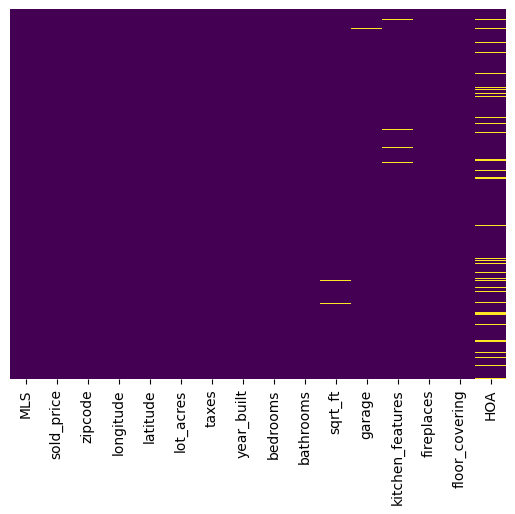

In [451]:
# missingness matrix
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [452]:
#Mostly missing values in the HOA column, kitchen features and sqrt ft column.

In [453]:
# the initial visualisation didnt capture all the missing values
df.isnull().sum()
# we will have to decide later on how to deal with the missing values

# comment on outliers

# good thing about the outliers is the values can be reasonably inferred based on values of other features
#e.g. sqrt_ft would be higher is amount of fireplaces is higher
#also based on the description of HOA fees the more expensive the house the higher the HOA fees

MLS                   0
sold_price            0
zipcode               0
longitude             0
latitude              0
lot_acres            10
taxes                 0
year_built            0
bedrooms              0
bathrooms             6
sqrt_ft              56
garage                7
kitchen_features     33
fireplaces           25
floor_covering        1
HOA                 562
dtype: int64

In [454]:
#explaination of nulls

# interesting MLS payment plan for sqrt abd lot acres
#3050688

# no boundary for lot acres/fencing
#3059875

# lot acres is clearly there in some case and not in others

In [455]:
# sense checks 

# typically it wouldnt make sense for a house to have more bathrooms than bedrooms so lets check this

df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

# Check for rows where bathrooms are more than bedrooms
more_bathrooms_than_bedrooms = df[df['bathrooms'] > df['bedrooms']]

# check average sold price for more_bathrooms_than_bedrooms
print(more_bathrooms_than_bedrooms['sold_price'].mean())

# check average sold price for properties with less bathrooms or equal to bedrooms
less_bathrooms_than_bedrooms = df[df['bathrooms'] <= df['bedrooms']]
#print the average sold price for less_bathrooms_than_bedrooms
print(less_bathrooms_than_bedrooms['sold_price'].mean())

# common in luxury properties to have a toilet for each room and then extra toilets for guuests
# Convert 'bedrooms' and 'bathrooms' to numeric, coercing errors

#suggest a new feature later on of bathrooms per bedroom and see if it has any correlation

950959.4219934102
718316.4743465608


In [456]:
# Convert 'garage' to numeric, coercing errors
df['garage'] = pd.to_numeric(df['garage'], errors='coerce')

# Check for rows where the number of garages is greater than 10
rows_with_more_than_10_garages = df[df['garage'] > 10]

#905 is not verifiable perhaps remove
rows_with_more_than_10_garages.head(10)


,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
140,21814007,1695000.0,85742,-111.034883,32.441422,4.58,19488.82,2004,6,6.0,6923.0,15.0,"Dishwasher, Double Sink, Garbage Disposal, Ind...",5.0,Natural Stone,NaN
905,21712548,825000.0,85745,-111.103561,32.264041,24.92,16165.77,2005,5,6.0,5937.0,22.0,"Dishwasher, Garbage Disposal, Microwave, Oven",3.0,"Carpet, Concrete",0
1505,21613527,817034.0,85755,-110.984403,32.464579,0.24,416.45,2016,2,3.0,2880.0,30.0,"Dishwasher, Freezer, Garbage Disposal, Refrige...",0.0,"Carpet, Ceramic Tile",167
1560,21803951,785000.0,85749,-110.756365,32.268453,8.77,9313.08,1975,4,3.0,3598.0,12.0,"Compactor, Desk, Dishwasher, Double Sink, Elec...",3.0,"Carpet, Ceramic Tile",NaN
2713,21803669,685000.0,85749,-110.755687,32.303589,3.31,6845.07,2003,3,4.0,2854.0,12.0,"Dishwasher, Electric Range, Garbage Disposal, ...",1.0,"Carpet, Ceramic Tile, Wood",NaN
2961,21912797,620000.0,85641,-110.728920,31.920157,8.37,5128.38,2001,3,3.0,3248.0,12.0,"Desk, Dishwasher, Double Sink, Electric Range,...",1.0,Ceramic Tile,NaN
3974,21829407,540000.0,85749,-110.780466,32.251520,1.49,4034.02,1989,4,4.0,3033.0,11.0,"Dishwasher, Double Sink, Garbage Disposal, Laz...",1.0,Natural Stone,NaN
4455,21222896,550000.0,85730,-110.756556,32.181148,9.10,6656.60,1960,7,5.0,4072.0,20.0,"Compactor, Dishwasher, Garbage Disposal, Refri...",2.0,"Carpet, Ceramic Tile, Mexican Tile, Other",0
4759,21808396,560000.0,85742,-111.054465,32.383574,9.55,9348.83,1982,4,5.0,4282.0,13.0,"Dishwasher, Garbage Disposal, Gas Range, Lazy ...",1.0,"Carpet, Ceramic Tile, Natural Stone",NaN


In [457]:
# garage 3 doesnt neccissaruly mean 3 garages
# 21324646 has 3 spaces but 1 garage
# 21222896 actually has 20 garages

In [458]:
# rows where taxes = 0
zero_taxes = df[df['taxes']==0]
zero_taxes.shape[0]

#zero taxes
zero_taxes.head(20)

#~approx 50% of the properties with 0 taxes
# belongs to a special development

#or taxes are indeed 0 from online listings

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
101,21814436,1450000.0,85624,-110.738083,31.533643,164.30,0.0,1997,1,1.0,3576.0,0.0,Missing: All Appliances,0.0,Concrete,NaN
196,21624122,1547664.0,85719,-110.934183,32.244512,0.20,0.0,2016,2,3.0,3346.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator",1.0,"Carpet, Natural Stone",125
377,21706833,1408464.0,85719,-110.938327,32.242829,0.24,0.0,2016,2,3.0,3346.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator",1.0,"Carpet, Natural Stone",125
723,21624132,1048842.0,85719,-110.938291,32.242845,0.23,0.0,2016,2,3.0,3346.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator",1.0,"Carpet, Natural Stone",125
725,21730800,1069000.0,85719,-110.939051,32.243662,0.20,0.0,2018,3,3.0,3346.0,3.0,"Dishwasher, Freezer, Garbage Disposal, Gas Ran...",1.0,"Carpet, Natural Stone",125
775,21730798,1007583.0,85719,-110.938306,32.243724,0.21,0.0,2018,3,3.0,3002.0,2.0,"Dishwasher, Garbage Disposal, Gas Range, Refri...",1.0,"Carpet, Wood, Other: Porcelain/Engineered",125
800,21730799,972877.0,85719,-110.939406,32.243494,0.21,0.0,2018,3,3.0,3002.0,2.0,"Dishwasher, Garbage Disposal, Gas Range, Pantr...",1.0,"Carpet, Other: Porcelain",125
909,21730830,985368.0,85719,-110.939446,32.243699,0.21,0.0,2018,3,3.0,3002.0,2.0,"Dishwasher, Garbage Disposal, Gas Range, Refri...",1.0,"Carpet, Wood, Other: Porcelain/Engineered",125
930,21730801,950795.0,85719,-110.938701,32.243375,0.20,0.0,2018,3,3.0,2580.0,3.0,"Dishwasher, Garbage Disposal, Gas Range, Pantr...",1.0,"Carpet, Wood, Other: Porcelain/Engineered",125
1066,21730831,900000.0,85719,-110.939027,32.243327,0.20,0.0,2018,3,3.0,2580.0,3.0,"Dishwasher, Freezer, Garbage Disposal, Gas Ran...",1.0,"Carpet, Natural Stone",125


In [459]:
# check rows top 5 HOA fees
df.sort_values(by='HOA', ascending=False).head(5)

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
4263,21801566,580000.0,85749,-110.779301,32.299951,0.48,6153.51,1996,3,3.0,2934.0,3.0,"Dishwasher, Garbage Disposal, Gas Range, Islan...",1.0,Wood,99.66
4379,21324554,550000.0,85715,-110.836870,32.258530,0.21,4290.00,2006,4,2.0,3078.0,3.0,"Dishwasher, Refrigerator, Microwave, Oven",0.0,"Carpet, Ceramic Tile, Wood",99
1801,21811029,780000.0,85745,-110.986212,32.217872,0.08,2912.00,2012,3,3.0,2720.0,0.0,"Dishwasher, Garbage Disposal, Pantry: Closet, ...",0.0,Concrete,99
1884,21828575,770000.0,85745,-110.986678,32.219062,0.07,3801.79,2008,3,2.0,2100.0,2.0,"Dishwasher, Garbage Disposal, Gas Range, Pantr...",1.0,"Concrete, Wood, Other: Mesquite wood floors",99
3252,21902966,630000.0,85745,-110.987028,32.218674,0.10,4443.27,2012,4,3.0,1867.0,2.0,"Dishwasher, Garbage Disposal, Gas Range, Refri...",0.0,Concrete,99


In [460]:
# show rows that have the same longitude,latitude as another row 

# this is to check for duplicate rows
df[df.duplicated(['longitude','latitude'],keep=False)].sort_values(by='longitude')


,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
946,21608590,695000.0,85645,-111.183593,31.702330,72.00,2480.58,0,4,4.0,2272.0,2.0,"Dishwasher, Refrigerator, Oven",2.0,Ceramic Tile,0
967,3058213,695000.0,85645,-111.183593,31.702330,NaN,2480.58,1932,4,4.0,NaN,2.0,"Dishwasher, Double Sink, Gas Range, Refrigerat...",NaN,Ceramic Tile,NaN
269,21221601,1325000.0,85658,-111.099960,32.470520,0.33,7030.50,2008,2,3.0,2911.0,2.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",2.0,"Carpet, Mexican Tile, Natural Stone, Wood",550
309,21602274,1175000.0,85658,-111.099960,32.470520,0.33,11407.46,2008,3,4.0,3388.0,2.0,"Dishwasher, Refrigerator, Microwave, Oven",2.0,Wood,550
4638,21726531,569000.0,85742,-111.074849,32.387779,4.34,6652.92,2002,4,3.0,3140.0,3.0,"Dishwasher, Double Sink, Garbage Disposal, Isl...",1.0,"Carpet, Mexican Tile",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,21419514,750000.0,85749,-110.704338,32.246575,5.15,5575.64,1991,4,4.0,3484.0,2.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",3.0,"Carpet, Mexican Tile",18
1347,21907825,850000.0,85749,-110.704338,32.246575,5.15,7199.74,1991,4,4.0,3815.0,2.0,"Desk, Dishwasher, Garbage Disposal, Gas Range,...",2.0,"Carpet, Mexican Tile",20
1780,21703450,735000.0,85749,-110.704338,32.246575,5.15,6628.00,1991,4,4.0,3484.0,2.0,"Desk, Dishwasher, Garbage Disposal, Pantry: Ca...",3.0,"Carpet, Mexican Tile, Wood",19
1072,21519475,863750.0,85749,-110.699960,32.267049,3.28,4843.94,1992,3,4.0,3049.0,3.0,"Compactor, Dishwasher, Garbage Disposal, Refri...",4.0,"Carpet, Ceramic Tile",120


In [461]:
# mls's can change for properties that are relisted example with 21602274
'''
https://www.tucsongolfestates.com/golf-course-homes/real-estate/6302-W-Sunlit-Bridge-Place-Marana-AZ-85658-mls_21602274/?pg=198&OrderBy=-ListPrice&p=y&m=20091028173201638455000000&n=y
https://www.trulia.com/home/6302-w-sunlit-bridge-pl-marana-az-85658-87925502'''

# drop the duplicate with the lower sold_price as it is likely to be an older listing
df.drop_duplicates(subset=['longitude','latitude'],keep='first',inplace=True)

#check new shape
df.shape

# 1.2% of the data was dropped but imo it is justfiied becuase wed want the data to reflect the most recent listings


(4940, 16)

In [462]:
#most common longitude in the duplicates
df[df.duplicated(['longitude','latitude'],keep=False)].sort_values(by='longitude')['longitude'].value_counts().head(5)

Series([], Name: count, dtype: int64)

In [463]:
# duplicate row check
# there are no duplicate rows in the dataset
df.duplicated().sum()

0

In [464]:
# describe the dataset 
df.describe()


# sqrt_ft is nor acruallt the square root of sq_ft
# MLS number is a uniques identifier for each house (might be able to drop this column) should be object type
# sold_price is a good potential target variable (could be int type)
# zipcode is should be object type (categorical)
# longitude and latitude a both correctly float data types
# lot_acres in the correct data type(float) - the max value differs Significantly from the 75%th percentile (outliers)
# sq_ft is the correct data type(int)) - the max value differs Significantly from the 75%th percentile (outliers)
# taxes is the correct data type but could be rounded an int 
# bedrooms should be converted to int type, the max value differs Significantly from the 75%th percentile (outliers)
# bathrooms should be converted to int type, the max value differs Significantly from the 75%th percentile (outliers)
# sqrt_ft appears to be the square root of sqft, the max value differs Significantly from the 75%th percentile (outliers)
# fireplace is the correct data type but could be rounded to int
# further investigation would be the check the distribution of lot_acres, sq_ft, bedrooms, bathrooms and sqrt_ft
# to see if the outliers are valid or not
# unusual values for 0's e.g. year_built,sqrt_ft
# bathrooms contained .5 values which should be rounded up 



,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces
count,4.940000e+03,4.940000e+03,4940.000000,4940.000000,4940.000000,4932.000000,4.940000e+03,4940.000000,4940.000000,4934.000000,4889.000000,4933.000000,4917.000000
mean,2.128579e+07,7.747359e+05,85723.077126,-110.912019,32.308775,4.699303,9.425499e+03,1992.297773,3.934818,3.830462,3715.875148,2.818772,1.882449
std,2.342061e+06,3.191187e+05,38.072638,0.120903,0.178276,51.986913,1.739851e+05,65.856715,1.248689,1.391231,1119.338391,1.197708,1.135640
min,3.042851e+06,1.690000e+05,85118.000000,-112.520168,31.356362,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1100.000000,0.000000,0.000000
25%,2.140733e+07,5.850000e+05,85718.000000,-110.979302,32.277704,0.580000,4.790847e+03,1987.000000,3.000000,3.000000,3046.000000,2.000000,1.000000
50%,2.161495e+07,6.750000e+05,85737.000000,-110.923351,32.318546,0.990000,6.220420e+03,1999.000000,4.000000,4.000000,3514.000000,3.000000,2.000000
75%,2.180509e+07,8.350000e+05,85749.000000,-110.858978,32.394877,1.750000,8.079005e+03,2006.000000,4.000000,4.000000,4131.000000,3.000000,3.000000
max,2.192856e+07,5.300000e+06,86323.000000,-109.454637,34.927884,2154.000000,1.221508e+07,2019.000000,36.000000,36.000000,22408.000000,30.000000,9.000000


Describe For Object Variables

In [465]:
# each of the categorical features have a high cardinality it may be worth looking later on as
#the high cardinality can cause problems with model complexity
# HOA fees has a high cardinality and should be continuous
df.describe(include=[object])

,kitchen_features,floor_covering,HOA
count,4908,4939,4383
unique,1852,309,380
top,"Dishwasher, Garbage Disposal, Refrigerator, Mi...","Carpet, Ceramic Tile",0
freq,1699,1224,819


### Data Cleaning And Preprocessing

Handling The Missing Values

In [466]:
# In the section  below we will look at the outliers in the dataset and see how they came about 

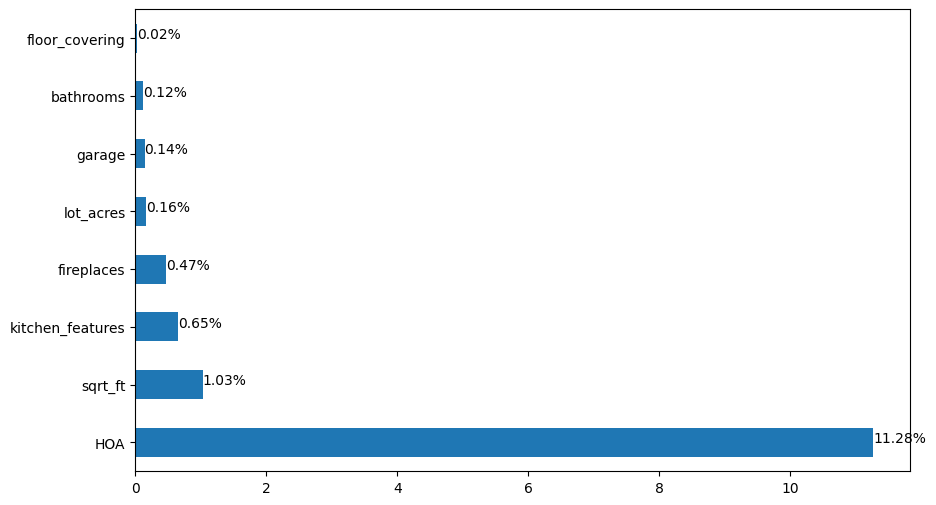

In [467]:
# we can drop the mls_columns


# calculate the percentage of missing values in each column
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

# show as a bar chart and dont include columns with 0% missing values
missing_percentage_sorted[missing_percentage_sorted != 0].plot(kind='barh',figsize=(10,6))

# include percentage level on the bar chart
for index, value in enumerate(missing_percentage_sorted[missing_percentage_sorted != 0]):
    plt.text(value, index, str(round(value,2)) + '%')


In [468]:
# df without null values
#df_without_null = df.dropna()

# check the describe
#df_without_null.describe()

# show most common zipcode
#df_without_null['zipcode'].value_counts().head(10)

In [469]:
# Specify the column you're interested in
column_with_nulls = 'sqrt_ft'

# Create a new DataFrame with only rows where the specified column is null
null_rows_df = df[df[column_with_nulls].isnull()]
null_rows_df.head()

# after checking the actually checking listingz online it appears that sqrt_ft should be available for all listings

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,NaN,NaN,"Dishwasher, Garbage Disposal, Refrigerator",5.0,"Natural Stone, Other: Rock",NaN
490,3055989,950000.0,85646,-111.073405,31.619537,4.40,13193.80,2008,3,7.0,NaN,4.0,"Compactor, Dishwasher, Double Sink, Pantry: Bu...",3.0,"Mexican Tile, Wood, Other",NaN
1064,3056708,785045.0,85646,-110.942060,31.552399,73.42,20761.40,2000,2,6.0,NaN,2.5,"Compactor, Dishwasher, Double Sink, Garbage Di...",7.0,"Ceramic Tile, Wood",NaN
1373,3059704,750000.0,85622,-111.001762,31.841975,2.72,7169.90,1995,6,7.0,NaN,3.0,"Desk, Dishwasher, Double Sink, Garbage Disposa...",3.0,Ceramic Tile,NaN
1659,3055188,700000.0,85646,-111.046366,31.623839,NaN,6740.66,2007,3,4.0,NaN,3.0,"Dishwasher, Double Sink, Freezer, Garbage Disp...",NaN,Natural Stone,157


In [470]:
# check rows with null values for kitchen_features
null_rows_df_k = df[df['kitchen_features'].isnull()]

# lets investigate the bull rows for kitchen_features from online listings
null_rows_df_k.head()

# example https://cgktucsonrealestate.com/sold-listing/detail/103734263/1040_Cocula_Court-Rio_Rico-AZ
# example https://cgktucsonrealestate.com/sold-listing/detail/5802793/87_CLARK_CROSSING_Road-Tubac-AZ?listingSort=RELEVANCE&layoutType=grid&mapType=grid&page=1&pageSize=24&isSearching=true&siteId=58340&listingSource=sold%20listings&condition=%7B%22location%22:%7B%22none%22:[%2221514843%22]%7D%7D&uiConfig=%7B%7D&zoom=12&mapSearch=false&timeline=true&listingSortOptions=[%7B%22label%22:%22Default%22,%22value%22:%22RELEVANCE%22%7D,%7B%22label%22:%22Most%20Recent%22,%22value%22:%22MLS_LIST_DATE_L_DESC%22%7D,%7B%22label%22:%22Price-Highest%22,%22value%22:%22PRICE_DESC%22%7D,%7B%22label%22:%22Price-Lowest%22,%22value%22:%22PRICE_ASC%22%7D,%7B%22label%22:%22Beds%20(Most)%22,%22value%22:%22BEDROOMS_DESC%22%7D,%7B%22label%22:%22Baths%20(Most)%22,%22value%22:%22BATHS_DESC%22%7D,%7B%22label%22:%22Year%20Built%20(Newest)%22,%22value%22:%22BUILT_YEAR_DESC%22%7D]&timezone=GMT%2B0000&source=search

# it appears that some listing online line do not have kitchen features listed as a heading not neccessarily missing, sometimes its included in the description

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
141,21815257,169000.0,85648,-110.918513,31.451945,0.52,80.83,2018,4,3.0,1700.0,2.0,NaN,0.0,Ceramic Tile,NaN
259,21514843,1200000.0,85646,-111.040290,31.594518,91.70,8473.86,1925,6,5.0,6884.0,0.0,NaN,7.0,"Carpet, Concrete",0
385,21119508,1000000.0,85742,-111.031723,32.440190,4.13,3861.65,2009,6,6.0,6520.0,4.0,NaN,3.0,Other,50
437,21402489,900000.0,85718,-110.876201,32.333403,1.35,11066.00,2013,5,5.0,5299.0,3.0,NaN,3.0,Other,145
629,21318982,900000.0,85745,-111.113182,32.242099,7.74,18509.30,2013,5,6.0,9284.0,3.0,NaN,4.0,"Ceramic Tile, Wood, Other",250


In [471]:
# check nan values in lot_acres
null_rows_df_l = df[df['lot_acres'].isnull()]
null_rows_df_l.head()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
1659,3055188,700000.0,85646,-111.046366,31.623839,NaN,6740.66,2007,3,4.0,NaN,3.0,"Dishwasher, Double Sink, Freezer, Garbage Disp...",NaN,Natural Stone,157
2564,3051223,680000.0,85622,-111.000925,31.836922,NaN,4158.40,2007,3,4.0,NaN,3.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1.0,"Carpet, Ceramic Tile",100
2939,3060029,655000.0,85614,-110.971212,31.835117,NaN,6433.00,2001,3,4.0,NaN,3.0,"Dishwasher, Double Sink, Electric Range, Garba...",NaN,"Carpet, Ceramic Tile",83.33
3420,3059875,605000.0,85622,-111.009941,31.839620,NaN,6134.56,2012,4,4.0,NaN,2.0,"Compactor, Dishwasher, Double Sink, Garbage Di...",NaN,"Carpet, Ceramic Tile",85
3530,3050480,580000.0,85622,-111.007069,31.846199,NaN,4498.01,1987,3,3.0,NaN,5.0,"Dishwasher, Double Sink, Electric Range, Garba...",1.0,"Carpet, Mexican Tile",NaN


In [472]:

# df where fireplace is null
null_rows_df_f = df[df['fireplaces'].isnull()]

# show null values
print(null_rows_df_f.shape)

# shape of null_rows df when ssqrt_ft is also null
null_rows_df_f_sqrt = null_rows_df_f[null_rows_df_f['sqrt_ft'].isnull()]

# print shape
print(null_rows_df_f_sqrt.shape)

# interestingly all the null values for fireplace are also bull for sqrt_ft
null_rows_df_f.head(5)

# upon investigation of the online listing it appears that fireplace and sqrt_ft are listed and sometimes not this is not a missing value but rather a data entry error/ recommendation would be to scrape

(23, 16)
(23, 16)


,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
1659,3055188,700000.0,85646,-111.046366,31.623839,NaN,6740.66,2007,3,4.0,NaN,3.0,"Dishwasher, Double Sink, Freezer, Garbage Disp...",NaN,Natural Stone,157
1729,3044500,675000.0,85629,-110.961128,31.869810,1.02,4662.64,2007,3,4.0,NaN,3.0,"Desk, Dishwasher, Garbage Disposal, Gas Range,...",NaN,"Carpet, Mexican Tile, Wood, Other: Tile-Other",149.5
1730,3053678,700000.0,85645,-111.239637,31.662369,172.76,7501.42,2000,3,3.0,NaN,2.0,"Dishwasher, Electric Range, Garbage Disposal, ...",NaN,"Carpet, Ceramic Tile, Mexican Tile",NaN
1863,3052969,750000.0,85622,-111.002640,31.846861,4.58,4578.00,1977,5,4.0,NaN,4.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",NaN,"Natural Stone, Other: Travertine & Slate",NaN
2025,3044867,660000.0,85614,-110.969465,31.836723,3.60,5526.00,2007,3,NaN,NaN,3.0,"Desk, Dishwasher, Garbage Disposal, Gas Range,...",NaN,"Carpet, Other: Tile-Other","1,000"


In [473]:
# rows with null values for HOA
null_rows_df = df[df['HOA'].isnull()]

# show null values
null_rows_df

# upon investigation of the online listing it appears that HOA has a value of 0 for most of the listing with null values

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,NaN,NaN,"Dishwasher, Garbage Disposal, Refrigerator",5.0,"Natural Stone, Other: Rock",NaN
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.0,4.0,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4.0,"Ceramic Tile, Laminate, Wood",NaN
10,21900396,2776518.0,85640,-111.045441,31.562121,147.18,7330.36,1935,5,5.0,5067.0,5.0,"Freezer, Refrigerator, Appliance Color: Stainl...",5.0,"Concrete, Natural Stone, Wood",NaN
39,4113243,2200000.0,85640,-111.044630,31.562185,147.18,3902.44,1935,5,4.5,4963.0,5.0,"Dishwasher, Freezer, Garbage Disposal, Pantry:...",4.0,"Carpet, Mexican Tile",NaN
49,21818418,1800000.0,86024,-111.228462,34.596971,59.30,4509.90,2003,2,3.0,1999.0,2.0,"Dishwasher, Garbage Disposal, Gas Range, Refri...",1.0,"Carpet, Wood, Other: Brick",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,21906583,526710.0,85748,-110.728390,32.221871,9.18,3390.67,1960,4,3.0,2284.0,0.0,"Dishwasher, Electric Range, Refrigerator, Coun...",1.0,"Ceramic Tile, Concrete",NaN
4995,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3.0,3601.0,3.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1.0,"Carpet, Ceramic Tile",NaN
4997,21832452,475000.0,85192,-110.755428,32.964708,12.06,1000.00,1969,3,2.0,1772.0,0.0,"Dishwasher, Electric Range, Island, Refrigerat...",0.0,Ceramic Tile,NaN
4998,21900515,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4.0,3724.0,3.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1.0,"Carpet, Ceramic Tile",NaN


In [474]:
# describe nulls value
null_rows_df.describe()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces
count,5.570000e+02,5.570000e+02,557.000000,557.000000,557.000000,555.000000,557.000000,557.000000,557.000000,556.000000,540.000000,550.000000,553.000000
mean,2.059578e+07,7.584960e+05,85715.842011,-110.919520,32.232100,11.271063,7561.945835,1988.086176,4.217235,3.994604,3712.212963,2.822727,1.866184
std,4.594348e+06,3.410640e+05,47.559922,0.143236,0.256749,83.104615,28217.718145,23.606481,2.378983,2.674869,1383.932753,1.785372,1.135796
min,3.046317e+06,1.690000e+05,85192.000000,-111.299663,31.361562,0.000000,0.000000,1900.000000,1.000000,1.000000,1484.000000,0.000000,0.000000
25%,2.180364e+07,5.800000e+05,85712.000000,-111.026773,32.232115,0.830000,4518.270000,1977.000000,3.000000,3.000000,3015.000000,2.000000,1.000000
50%,2.182174e+07,6.590000e+05,85719.000000,-110.933628,32.288690,1.680000,5895.000000,1995.000000,4.000000,4.000000,3436.000000,3.000000,2.000000
75%,2.190416e+07,8.150000e+05,85747.000000,-110.829223,32.334380,3.910000,7600.920000,2005.000000,5.000000,4.000000,4114.000000,3.000000,2.000000
max,2.192856e+07,4.500000e+06,86024.000000,-109.980961,34.596971,1707.000000,668059.000000,2019.000000,36.000000,36.000000,22408.000000,15.000000,7.000000


Handling Nulls: provisional solution

In [475]:
# convert HOA datatyoe so it can be imputed
df['HOA'] = df['HOA'].str.replace(',','').astype('float') 

In [476]:
unimputted_describe = df.describe()
unimputted_describe

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,fireplaces,HOA
count,4.940000e+03,4.940000e+03,4940.000000,4940.000000,4940.000000,4932.000000,4.940000e+03,4940.000000,4940.000000,4934.000000,4889.000000,4933.000000,4917.000000,4383.000000
mean,2.128579e+07,7.747359e+05,85723.077126,-110.912019,32.308775,4.699303,9.425499e+03,1992.297773,3.934818,3.830462,3715.875148,2.818772,1.882449,103.207969
std,2.342061e+06,3.191187e+05,38.072638,0.120903,0.178276,51.986913,1.739851e+05,65.856715,1.248689,1.391231,1119.338391,1.197708,1.135640,550.735519
min,3.042851e+06,1.690000e+05,85118.000000,-112.520168,31.356362,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1100.000000,0.000000,0.000000,0.000000
25%,2.140733e+07,5.850000e+05,85718.000000,-110.979302,32.277704,0.580000,4.790847e+03,1987.000000,3.000000,3.000000,3046.000000,2.000000,1.000000,8.000000
50%,2.161495e+07,6.750000e+05,85737.000000,-110.923351,32.318546,0.990000,6.220420e+03,1999.000000,4.000000,4.000000,3514.000000,3.000000,2.000000,55.000000
75%,2.180509e+07,8.350000e+05,85749.000000,-110.858978,32.394877,1.750000,8.079005e+03,2006.000000,4.000000,4.000000,4131.000000,3.000000,3.000000,135.000000
max,2.192856e+07,5.300000e+06,86323.000000,-109.454637,34.927884,2154.000000,1.221508e+07,2019.000000,36.000000,36.000000,22408.000000,30.000000,9.000000,20000.000000


In [477]:
# based on observing the listings it seems that some properties genuinely do not have HOA listings on websites   
# there is no real reason to believe that the null values are erroneous. it reasonable replace HOA Nan with 0
# whats noteworthy is homes not in HOA generally have a higher lot_acres


# remove values with 0 for year built with median
df['year_built'] = df['year_built'].replace(0,df['year_built'].median())

# impute Bathrooms with median
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].value_counts().index[0])

# impute Nan values in HOA with 0
df['HOA'] = df['HOA'].fillna(0)

# impute sqrt_ft with average sqrt_ft per bathroom since bathrooms is a good predictor of sqrt_ft
df['sqrt_ft'] = df['sqrt_ft'].fillna(df['sqrt_ft'].median())

# provisional imputation

# impute kitchen features with most common kitchen features
df['kitchen_features'] = df['kitchen_features'].fillna(df['kitchen_features'].value_counts().index[0])

# impute fireplace with most common
df['fireplaces'] = df['fireplaces'].fillna(df['fireplaces'].value_counts().index[0])

# impute lot_acres with median
df['lot_acres'] = df['lot_acres'].fillna(df['lot_acres'].median())

# impute Garage with most 
df['garage'] = df['garage'].fillna(df['garage'].value_counts().index[0])

# impute floor_covering 
df['floor_covering'] = df['floor_covering'].fillna(df['floor_covering'].value_counts().index[0])


In [478]:
new_describe = df.describe()

In [479]:
# compare the mean and median of this describe compared to the original describe to check for any significant changesd

# mean and medians before  imputation
old_means = unimputted_describe.loc['mean']
old_medians = unimputted_describe.loc['50%']

# mean and medians after imputation
new_means = new_describe.loc['mean']
new_medians = new_describe.loc['50%']

# percentage change in means 
mean_change = ((old_means - new_means)/ old_means)*100

#percentage change in medians
median_change =((old_medians - new_medians)/ old_medians)*100

# print the mean and median change for each  feature
print(mean_change,median_change)

MLS            0.000000
sold_price     0.000000
zipcode        0.000000
longitude     -0.000000
latitude       0.000000
lot_acres      0.127827
taxes          0.000000
year_built    -0.101555
bedrooms       0.000000
bathrooms      0.026333
sqrt_ft        0.056087
garage        -0.009110
fireplaces     0.218257
HOA           11.275304
Name: mean, dtype: float64 MLS            0.000000
sold_price     0.000000
zipcode        0.000000
longitude     -0.000000
latitude       0.000000
lot_acres      0.000000
taxes          0.000000
year_built     0.000000
bedrooms       0.000000
bathrooms      0.000000
sqrt_ft        0.000000
garage         0.000000
fireplaces     0.000000
HOA           18.181818
Name: 50%, dtype: float64


Handling Missing Values: Imputations (I can get it to work)

In [480]:
# # creeate of copy of df
# df_knn = df.copy()

# # drop categorical features
# df_knn.drop(['floor_covering','kitchen_features','fireplaces','garage','bathrooms'],axis=1,inplace=True)

# # drop mls_number
# df_knn.drop('MLS',axis=1,inplace=True)

# #drop HOA provisionallly
# df_knn.drop('HOA',axis=1,inplace=True)


# # perform KNN imputation
# imputer = KNNImputer(n_neighbors=5)
# df_knn = imputer.fit_transform(df_knn)

# # convert back to dataframe
# df_knn = pd.DataFrame(df_knn,columns=df.columns)

# # check the head
# df_knn.head()

In [481]:
# impute Nan value for sqrt_ft values depending on the number of bathsrooms
#average_sqrt_ft = df.groupby('bathrooms')['sqrt_ft'].median()
#average_sqrt_ft

In [482]:
# # drop rows with null values in columns floor_covering,bathrooms,garage,lot_acres,fireplace,kitchen_features,sqrt_ft
# # provisionally for now drop the nulls from HOA too
# df = df.copy()
# df.dropna(subset=['floor_covering','bathrooms','garage','lot_acres','fireplaces','kitchen_features','sqrt_ft','HOA'],inplace=True)

In [483]:
#might delete this cell


# # initially thought it was a categorical variable but it is a continuous variable
# high_cardinality_column = 'HOA'

# # Calculate the top 10 categories
# top_10 = df[high_cardinality_column].value_counts().nlargest(10)

# # Set the aesthetic style of the plots
# sns.set(style="whitegrid")

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_10.index, y=top_10.values)
# plt.title(f'Top 10 Occurrences in {high_cardinality_column}')
# plt.xlabel('Categories')
# plt.ylabel('Frequency')
# plt.show()

In [484]:
# after researching the meaning of the HOA columns, it likely that the values are the monthly HOA fees
# the definitions suggessts more luxurious house have higher HOA fees this is something we can investigate later on

In [485]:
# for column in df.select_dtypes(include=['object']).columns:
#     plt.figure(figsize=(10, 20))
#     sns.countplot(y=column, data=df)
#     plt.title(f'Distribution of {column}')
#     plt.show()

Data Type Conversions

In [486]:
# the only feature that is not in the right data type is zipcode
df['zipcode']=df['zipcode'].astype('object')
#  change MLS number to object type
df['MLS']=df['MLS'].astype('object')
#  change year built to float 
df['year_built']=df['year_built'].astype('int')
#  change price_sold to int
#['sold_price']=df['sold_price'].astype('int')
# change taxes to an int
df['taxes']=df['taxes'].astype('int')
# change bedrooms to an int 
df['bedrooms']=df['bedrooms'].astype('int')
# change bathrooms to an int type 
df['bathrooms']=df['bathrooms'].astype('int')
# change fireplace to an int
df['fireplaces']=df['fireplaces'].astype('int')
# change HOA to type int/ conversion didnt work immediately because its a string/and has commas
#df['HOA'] = df['HOA'].str.replace(',','').astype('float')

In [487]:
#  856 is the area code for Tuscon Arizon ('Vicinty')
#  857 is the area code for Tuscon Arizona ('Main')
#  859 is the area code for Show Low Arizona
#  851 is the area code for Mesa Arizona
#  863 is the area code for Prescott Arizona
#  860 is the area code for Flagstaff Arizona
#  855 is the area code for Globe Arizona
#  Most of the properties on the listing a situated Tucson Arizona: 859, 851 and 863 are for different cities. It may be worth removing them since 1 row from each district. It is not enough rows to provide reliable inferences.

In [488]:
# percentage of houses with no HOA fees/ close to known mean. the pecentage befoe the imputation was 20%
(df['HOA'] == 0).sum() / df.shape[0] * 100

27.85425101214575

cross checking the daily average for 448 dollars and that about a 1/3rd of the population via 

https://phoenixagentmagazine.com/2023/04/21/nearly-one-third-of-arizona-homes-are-part-of-an-hoa-among-the-highest-percentages-in-the-nation/#:~:text=The%20average%20monthly%20HOA%20fee,%2C%20worth%20about%204%25%20more.

it suggests that this dataset is not entirely representative of population of Tucson Arizona and biased

Dealing With Outliers

we should identify univariate outliers as they have the capacity sway the values of predictions (explain more later)

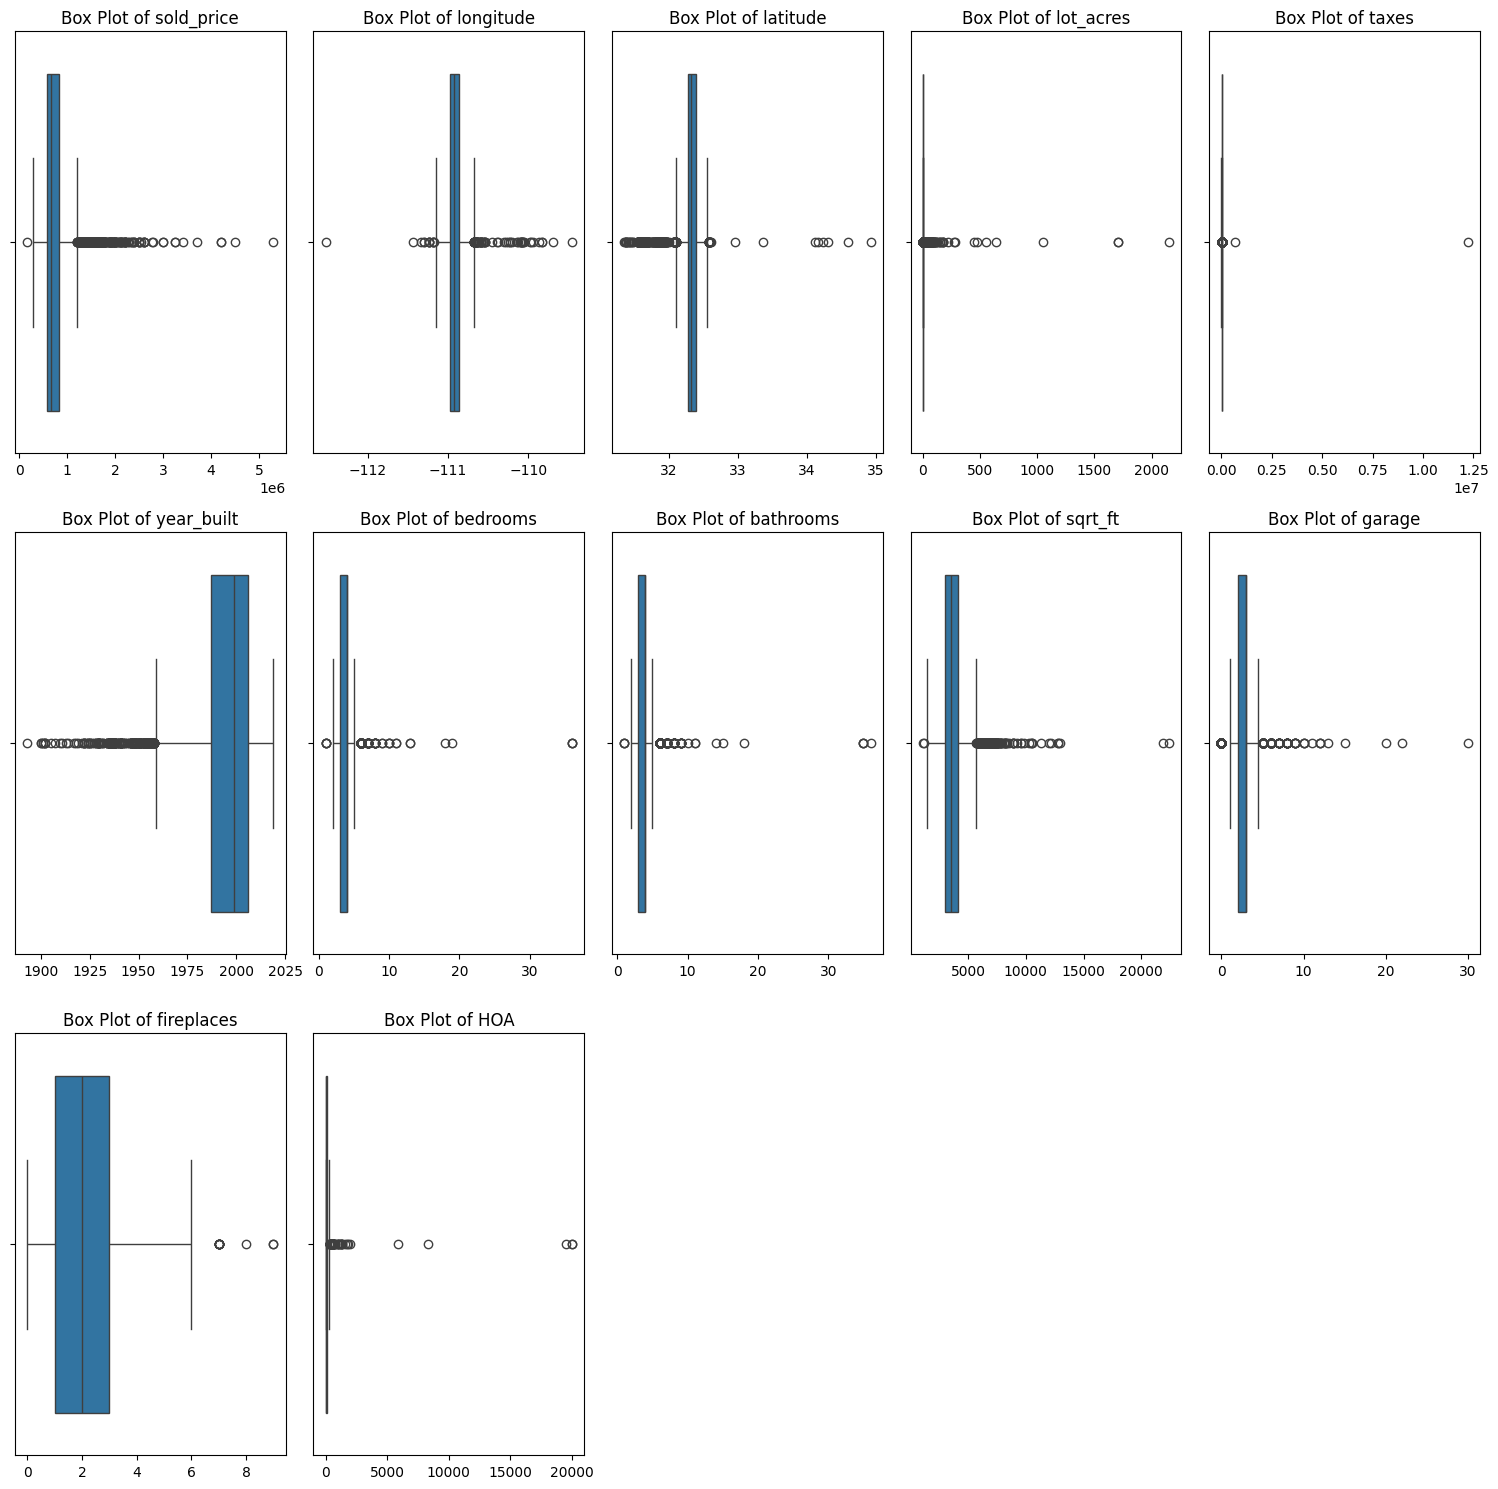

In [489]:

# Select only numerical columns (optional, depending on your dataset)
numerical_columns = df.select_dtypes(include=np.number).columns

# Determine the layout of your grid
n_cols = 5 # Number of columns in the grid
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the figure size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the numerical columns and create a box plot in each subplot
for i, column in enumerate(numerical_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel('')  # Optionally remove the x-label for neatness

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [490]:
def find_outliers_iqr(df, column):
    """
    Identify outliers in a dataframe column based on the IQR method.
    Returns a boolean series where True indicates the presence of an outlier.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Replace 'df' with your DataFrame variable
# Numeric columns list
numeric_cols = ['sold_price', 'longitude', 'latitude', 'lot_acres', 'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage', 'fireplaces']

# Apply the outlier detection function to each numeric column
outlier_mask = df[numeric_cols].apply(lambda col: find_outliers_iqr(df, col.name))

# Any row with at least one outlier
rows_with_outliers = df[outlier_mask.any(axis=1)]

#show the rows with outliers
rows_with_outliers

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272,1941,13,10,10500.0,0.0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0.00
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422,1997,2,2,7300.0,0.0,"Dishwasher, Garbage Disposal",5,"Natural Stone, Other",0.00
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482,1997,2,3,3514.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator",5,"Natural Stone, Other: Rock",0.00
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418,1930,7,5,9019.0,4.0,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4,"Ceramic Tile, Laminate, Wood",0.00
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393,1995,4,6,6396.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Carpet, Concrete",55.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,3052471,525000.0,85622,-111.038888,31.791324,0.95,3919,2010,3,3,3514.0,3.0,"Dishwasher, Double Sink, Electric Range, Garba...",1,"Carpet, Other: Marble",78.65
4992,3056450,525000.0,85614,-110.980945,31.824287,3.01,5122,2007,3,3,3514.0,3.0,"Dishwasher, Garbage Disposal, Gas Range, Refri...",1,"Concrete, Other: Cork",37.00
4995,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017,2005,5,3,3601.0,3.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1,"Carpet, Ceramic Tile",0.00
4997,21832452,475000.0,85192,-110.755428,32.964708,12.06,1000,1969,3,2,1772.0,0.0,"Dishwasher, Electric Range, Island, Refrigerat...",0,Ceramic Tile,0.00


In [491]:
# percentage of rows with outliers is less with 33%
len(rows_with_outliers)/len(df)*100

32.69230769230769

In [492]:
# which columns have the most outliers 
outlier_mask.sum()

sold_price    391
longitude     107
latitude      337
lot_acres     573
taxes         272
year_built    238
bedrooms      172
bathrooms     303
sqrt_ft       235
garage        377
fireplaces     12
dtype: int64

In [493]:

# checking the most extreme values for bedrooms on google it appears that the values are correct and not outliers
sorted_df = rows_with_outliers.sort_values(by='bedrooms', ascending=False).head(10)
sorted_df


,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
2111,4115949,550000.0,85645,-111.047350,31.701117,50.00,25113,1936,36,35,22408.0,0.0,Countertops: Stainless,1,"Ceramic Tile, Mexican Tile",0.0
2106,3056848,550000.0,85645,-111.047608,31.700763,50.00,25113,1936,36,35,3514.0,3.0,Prep Sink,1,"Ceramic Tile, Mexican Tile",0.0
3277,21623780,695000.0,85645,-111.047260,31.701407,50.00,6520,1936,36,35,21915.0,0.0,Refrigerator,1,"Ceramic Tile, Mexican Tile",0.0
635,21731756,895000.0,85749,-110.799667,32.253627,11.57,26110,1948,19,18,12154.0,0.0,"Dishwasher, Garbage Disposal, Pantry: Walk-In,...",3,"Carpet, Mexican Tile, Other: Multiple Types",0.0
969,21917718,950000.0,85712,-110.894127,32.238608,0.49,2623,1953,18,14,2850.0,0.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",0,Carpet,0.0
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272,1941,13,10,10500.0,0.0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0.0
35,21307177,2495000.0,85637,-110.740635,31.720431,131.00,1220,1999,13,15,13000.0,0.0,"Compactor, Dishwasher, Freezer, Garbage Dispos...",4,"Carpet, Ceramic Tile, Mexican Tile",0.0
4518,21908995,500000.0,85638,-110.082311,31.712638,555.60,4669,1934,11,11,5800.0,0.0,Pantry: Closet,1,"Vinyl, Wood",0.0
2099,21732543,625000.0,85624,-110.741221,31.615553,94.07,6269,1942,11,9,5396.0,0.0,"Dishwasher, Double Sink, Electric Range, Garba...",3,"Ceramic Tile, Concrete, Vinyl",0.0
843,21811210,925000.0,85748,-110.749963,32.220068,5.77,10220,2009,10,8,7315.0,4.0,"Dishwasher, Double Sink, Gas Range, Refrigerat...",1,Ceramic Tile,0.0


<Axes: >

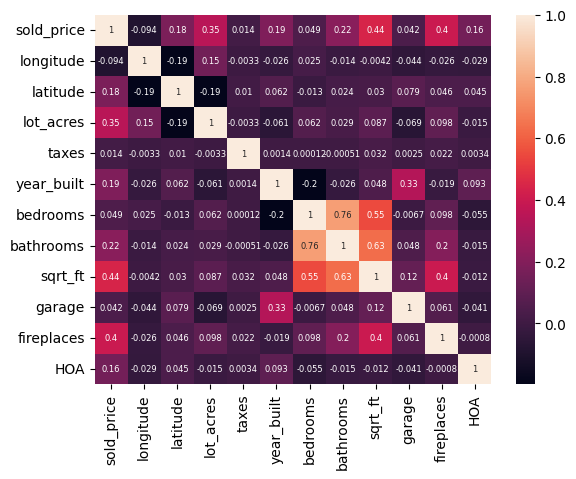

In [494]:
# make annotations font size abit smaller
sns.heatmap(rows_with_outliers.select_dtypes(include=np.number).corr(),annot=True,annot_kws={"size":6})
# the visualisation below shows correlations between the supposed outliers this might indicate the outlier are indeed valid values

In [495]:
# the outliers appear to be very correlated with each suggesting that they are valid values

In [496]:
# # provisionally we drop the outliers from the dataset because hurt our visualisations

# # Define a function to remove outliers based on IQR
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# # Apply the function to each column you want to clean
# # Replace 'column_name' with your column names
# cleaned_df = remove_outliers(df, df.select_dtypes(include=np.number).columns)

# # check the shape of the dataset
# cleaned_df.shape


# Univariate Analysis

Distribution Of Numerical Features

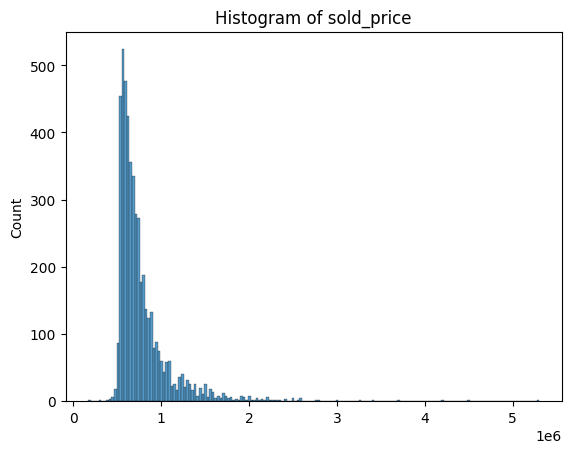

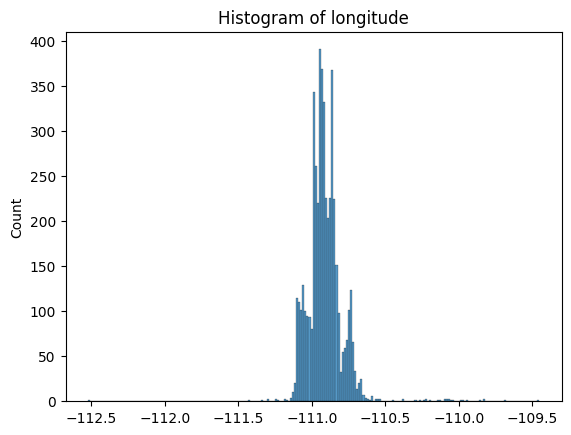

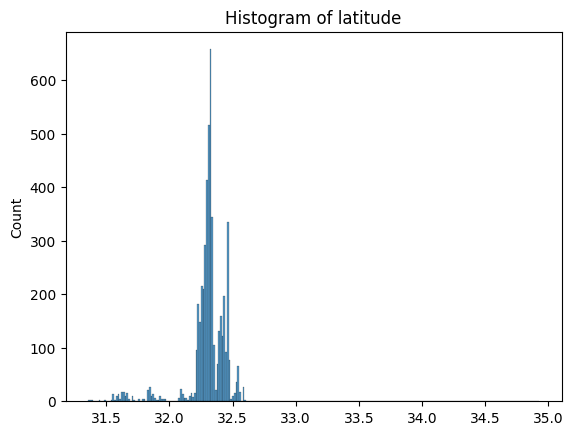

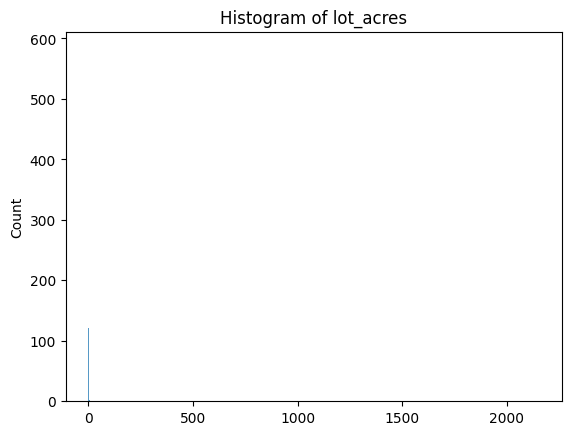

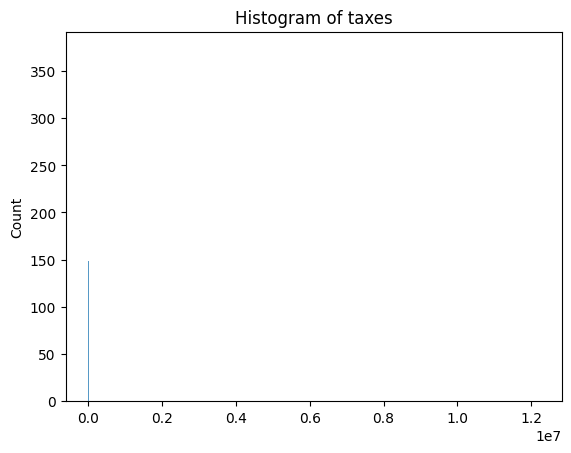

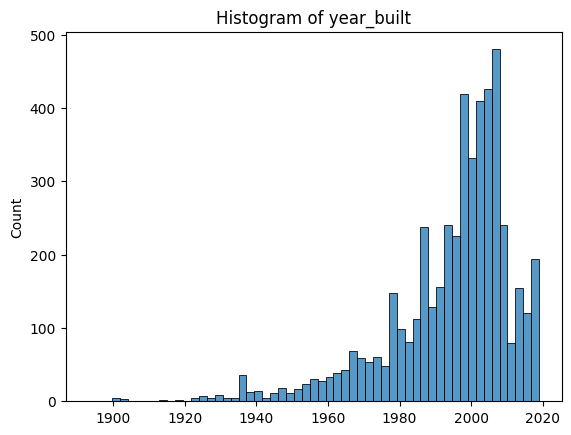

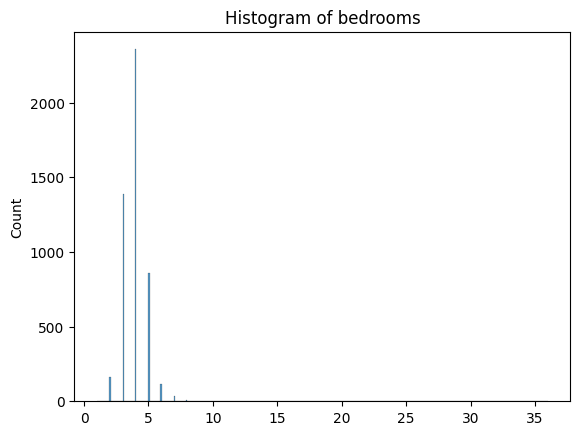

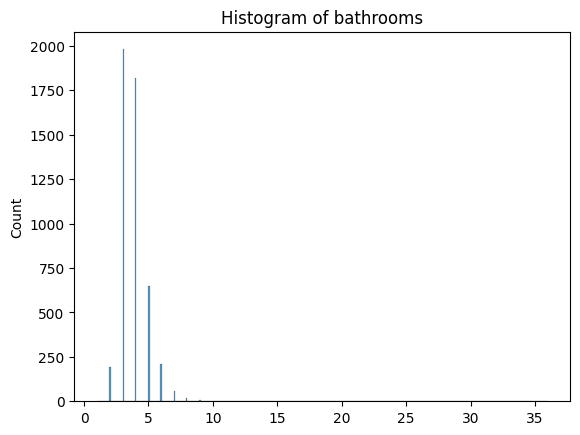

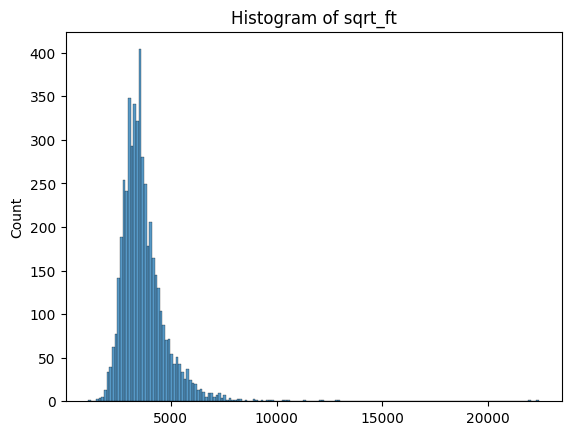

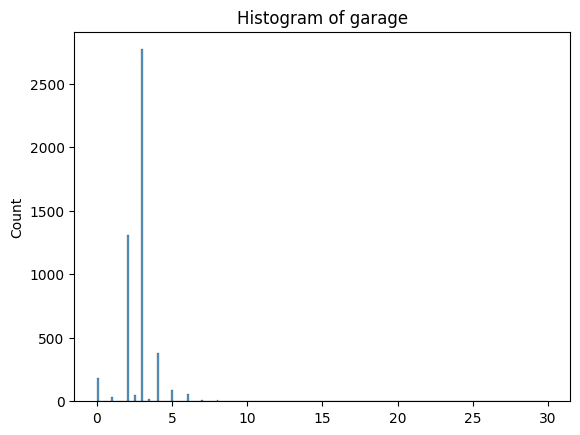

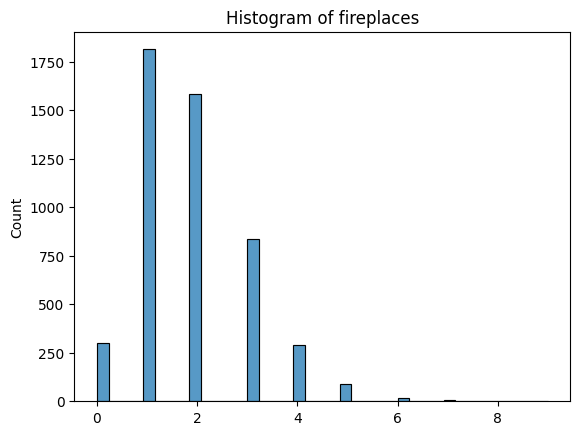

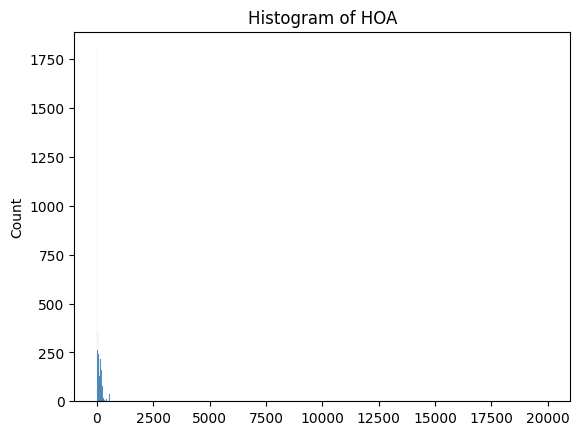

In [497]:
# sns.histplot for each numerical column not using grid layout

# renmove the outlier from the datasets and then plot the histograms

# Select only numerical columns (optional, depending on your dataset)
numerical_columns = df.select_dtypes(include=np.number).columns

# for loop to create a histogram for each numerical column
for i, column in enumerate(numerical_columns):
    sns.histplot(x=df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel('')  # Optionally remove the x-label for neatness
    plt.show()



<Axes: xlabel='lot_acres', ylabel='Count'>

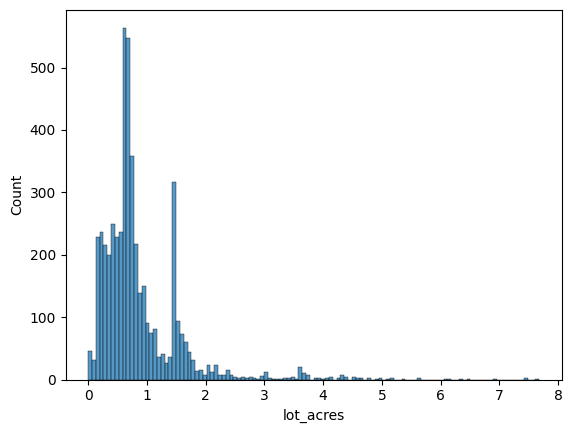

In [498]:
# lets see what happens when we apply log transformation to the lot_acres column

# Logarithmic Transformation (adding 1 to handle zeros)
log_transformed = np.log(df['lot_acres'] + 1)

sns.histplot(x=log_transformed)
#this scale looks alot better


<Axes: xlabel='lot_acres', ylabel='Count'>

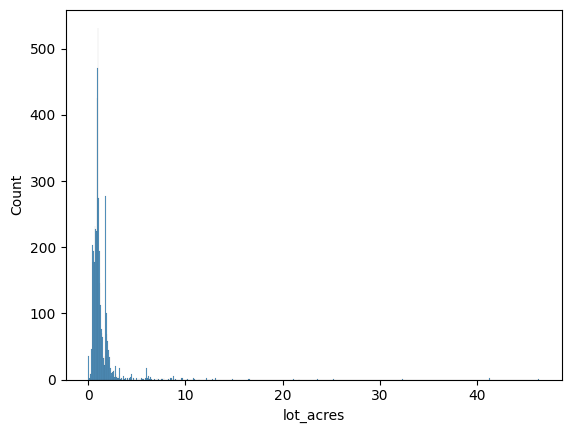

In [499]:
# Square Root Transformation
sqrt_transformed = np.sqrt(df['lot_acres'])

sns.histplot(x=sqrt_transformed)

In [500]:
# the dataset set is definately more palatable after the transformation should consider further transformation for to the modelling team

In [501]:
# describe for HOA
df['HOA'].describe()

count     4940.000000
mean        91.570957
std        519.778256
min          0.000000
25%          0.000000
50%         45.000000
75%        123.000000
max      20000.000000
Name: HOA, dtype: float64

In [502]:
# percentage of houses with no HOA fees/ close to known mean. the pecentage befoe the imputation was 20%
(df['HOA'] == 0).sum() / df.shape[0] * 100

27.85425101214575

# comments on distributinons w.r.t modeeling

- According to data from the 2018 5-year ACS, the largest proportion of homes were built between 1970 and 1979. However, the following decades had similar levels of housing development, with 74% of all homes in the Tucson area built between 1970 and 2009. source:https://mapazdashboard.arizona.edu/housing-age#:~:text=According%20to%20data%20from%20the,built%20between%201970%20and%202009. This is reflected in the dataset above since the 75% is ~ 2009

- As of October 2023, the median home size in Pima County, Arizona, was reported to be 1,868 square feet. However, in this more than 50% of the houses are larger than the average house in PIMA this seems abit unusual

- the average HOA fee 448 dollar/ approx 31.1% of home owner are in a HOA feehttps://tucson.com/business/investment/personal-finance/are-high-hoa-fees-scaring-homeowners-away/collection_3e8127a9-c8be-53ca-a64f-b7c235c14c8d.html
- further tests are needed/ if the data is not representative they must be careful



# Univariate Analysis Of Categorical Features

### zipcode

In [503]:
# zipcode has least cardinality
df['zipcode'].describe(include=[object])

count      4940
unique       56
top       85718
freq       1308
Name: zipcode, dtype: int64

In [504]:
# convert zipcode to a string
df['zipcode'] = df['zipcode'].astype('str')
# get the first 3 digits of all the zipcodes and see how many unique values there are
unique_vals = df['zipcode'].str[:3].value_counts()
# show the first 3 digts
print(unique_vals)

zipcode
857    4298
856     634
859       3
851       2
860       1
863       1
855       1
Name: count, dtype: int64


In [505]:
category_percentages = df['zipcode'].value_counts(normalize=True)*100
print(category_percentages)

zipcode
85718    26.477733
85750    15.587045
85755     9.271255
85749     7.995951
85658     5.769231
85737     5.647773
85742     3.198381
85745     3.117409
85739     3.097166
85716     2.165992
85704     1.902834
85715     1.862348
85743     1.538462
85719     1.518219
85641     1.376518
85646     1.234818
85748     1.214575
85614     0.951417
85712     0.850202
85623     0.627530
85622     0.566802
85730     0.546559
85637     0.546559
85747     0.303644
85629     0.283401
85701     0.283401
85705     0.242915
85624     0.202429
85611     0.182186
85630     0.182186
85645     0.161943
85619     0.141700
85711     0.121457
85648     0.101215
85621     0.101215
85640     0.080972
85615     0.060729
85601     0.040486
85643     0.040486
85710     0.040486
85610     0.040486
85602     0.040486
85609     0.020243
86024     0.020243
86323     0.020243
85118     0.020243
85605     0.020243
85929     0.020243
85541     0.020243
85713     0.020243
85625     0.020243
85935     0.020243
8560

Kitchen features

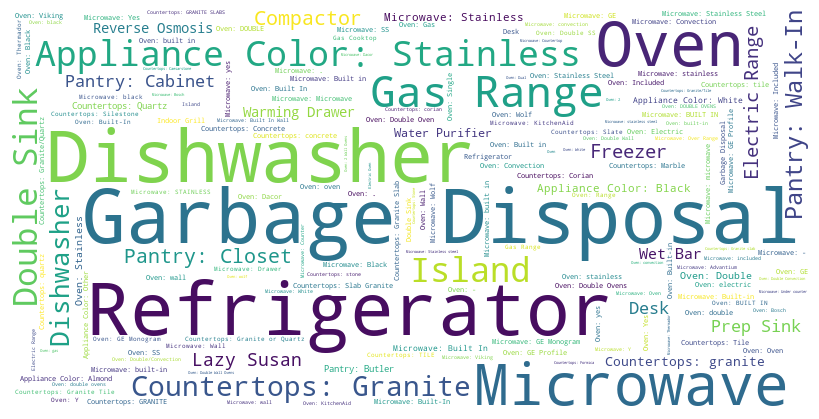

In [506]:
##most common words in kitchen features##


# Splitting the strings and flattening the list of lists
words = [word for sublist in df['kitchen_features'].str.split(',') for word in sublist]
# Counting the occurrences of each word
word_counts = Counter(words)
# Most common words
#most_common_words = word_counts.most_common()

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_counts)
# Plotting the WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show()

In [507]:
# ##most expensive kitchen features##


# # now checking the occurence of each word and the average sold price
# words = set(word for sublist in df['kitchen_features'].str.split(',') for word in sublist)
# for word in words:
#     df[word] = df['kitchen_features'].str.contains(word).astype(int)

# # Step 2: Calculate the average of 'another_column' for each word
# average_values = {}
# for word in words:
#     average = df[df[word] == 1]['sold_price'].mean()
#     average_values[word] = average

# # Step 3: Sort the dictionary by average values
# average_values = dict(sorted(average_values.items(), key=lambda item: item[1], reverse=True))

# average_values

# Extract unique words from the 'kitchen_features' column
words = set(word.strip() for sublist in df['kitchen_features'].str.split(',') for word in sublist)

# Initialize a dictionary to store the average sold prices
average_sold_prices = {}

# Calculate the average sold price for each word
for word in words:
    # Create a temporary boolean series to check if the word is present in 'kitchen_features'
    contains_word = df['kitchen_features'].str.contains(word, na=False)
    
    # Calculate the average sold price for listings containing the word
    average_price = df[contains_word]['sold_price'].mean()
    
    # Store the result in the dictionary
    average_sold_prices[word] = average_price

# Sort the dictionary by average sold price in descending order
sorted_average_sold_prices = dict(sorted(average_sold_prices.items(), key=lambda item: item[1], reverse=True))

In [508]:
# upon researching the meaning of the kitchen features it appears that the idea that the more luxurious kitchen
# appliances the higher the sold price is a feasible one 

Reducing The Cardinality Of Kitchen Features

In [509]:
# show kitchen
df['kitchen_features'].value_counts()

kitchen_features
Dishwasher, Garbage Disposal, Refrigerator, Microwave, Oven                                                                                                                                                 1731
Dishwasher, Garbage Disposal, Microwave, Oven                                                                                                                                                                268
Compactor, Dishwasher, Garbage Disposal, Refrigerator, Microwave, Oven                                                                                                                                       187
Dishwasher, Garbage Disposal, Refrigerator, Oven                                                                                                                                                             177
Dishwasher, Freezer, Garbage Disposal, Refrigerator, Microwave, Oven                                                                               

In [510]:
# Applying the new 'luxury' threshold based on the 80th percentile of the average sold prices for kitchen features
luxury_threshold_80th = pd.Series(df['sold_price']).quantile(0.80)

# Redefining the kitchen feature encoding using the 80th percentile threshold
df['kitchen_features'] = df['kitchen_features'].apply( lambda x: 'luxury' if any(feature in str(x) and average_values[feature] > luxury_threshold_80th for feature in average_values) else 'standard')

# value counts and normalise
df['kitchen_features'].value_counts(normalize=True)*100

kitchen_features
standard    82.449393
luxury      17.550607
Name: proportion, dtype: float64

Floor Covering

[('Carpet', 3472), (' Ceramic Tile', 1941), (' Natural Stone', 1222), (' Wood', 1183), ('Ceramic Tile', 567), (' Mexican Tile', 490), ('Concrete', 370), (' Concrete', 365), ('Natural Stone', 266), (' Other', 234), ('Mexican Tile', 155), (' Laminate', 73), (' Vinyl', 55), ('Wood', 35), ('Other', 33), (' Other: Travertine', 23), (' Other: Porcelain', 14), (' Other: Porcelain Tile', 14), (' Other: Brick', 12), (' Indoor/Outdoor', 8), ('Other: Porcelain Tile', 7), (' Other: Marble', 6), ('Laminate', 6), (' Other: Porcelain tile', 6), ('Other: Porcelain', 4), (' Other: Tile-Other', 4), (' Other: Flagstone', 3), (' Other: Saltillo', 3), (' Other: Travertine Tile', 3), ('Other: Travertine', 3), (' Other: Porcelain/Engineered', 3), (' Other: Slate', 3), (' Other: Cork', 3), (' Other: Brick Pavers', 2), (' Other: concrete tile', 2), ('Other: Flagstone', 2), ('Other: Porcelain tile', 2), ('Other: Brick', 2), (' Other: brick', 2), (' Other: porcelain tile', 2), (' Other: travertine', 2), (' Other

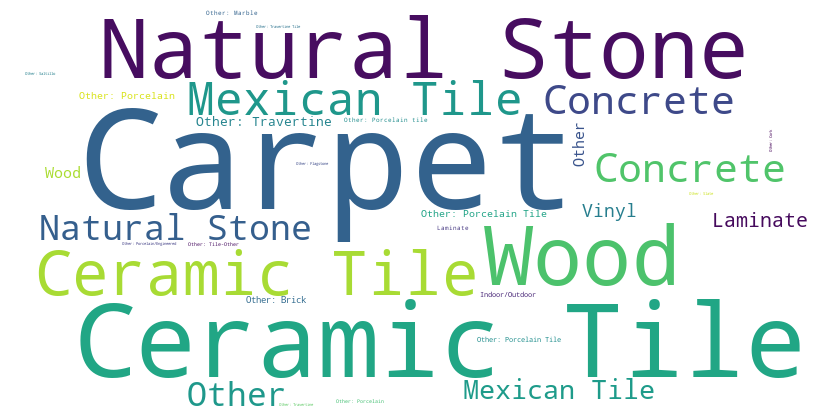

In [511]:
# analyse the floor covering column in the same way as the kitchen features column

# Splitting the strings and flattening the list of lists
words = [word for sublist in df['floor_covering'].str.split(',') for word in sublist]
# Counting the occurrences of each word
word_counts = Counter(words)
# Most common words
most_common_words = word_counts.most_common()
# printing the values out
print(most_common_words)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_counts)

# Plotting the WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show()

In [512]:
# Extract unique words from the 'floor_covering' column
words = set(word.strip() for sublist in df['floor_covering'].str.split(',') for word in sublist)

# Initialize a dictionary to store the average sold prices
average_sold_prices = {}

# Calculate the average sold price for each word
for word in words:
    # Create a temporary boolean series to check if the word is present in 'floor_covering'
    contains_word = df['floor_covering'].str.contains(word, na=False)
    
    # Calculate the average sold price for listings containing the word
    average_price = df[contains_word]['sold_price'].mean()
    
    # Store the result in the dictionary
    average_sold_prices[word] = average_price

# Sort the dictionary by average sold price in descending order
sorted_average_sold_prices = dict(sorted(average_sold_prices.items(), key=lambda item: item[1], reverse=True))

Reducing The Cardinality Of Floor Covering

In [513]:
# Applying the new 'luxury' threshold based on the 80th percentile of the average sold prices for kitchen features
luxury_threshold_80th = pd.Series(df['sold_price']).quantile(0.80)

# Redefining the kitchen feature encoding using the 80th percentile threshold
df['floor_covering'] = df['floor_covering'].apply( lambda x: 'luxury' if any(feature in str(x) and average_values[feature] > luxury_threshold_80th for feature in average_values) else 'standard')

# value counts and normalise
df['floor_covering'].value_counts(normalize=True)*100

floor_covering
standard    68.88664
luxury      31.11336
Name: proportion, dtype: float64

Bivariate Analysis

In [514]:
df.head()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272,1941,13,10,10500.0,0.0,standard,6,standard,0.0
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422,1997,2,2,7300.0,0.0,standard,5,luxury,0.0
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482,1997,2,3,3514.0,3.0,standard,5,luxury,0.0
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418,1930,7,5,9019.0,4.0,standard,4,standard,0.0
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393,1995,4,6,6396.0,3.0,standard,5,standard,55.0


Text(0.5, 1.0, 'Correlation Matrix of Numerical Columns')

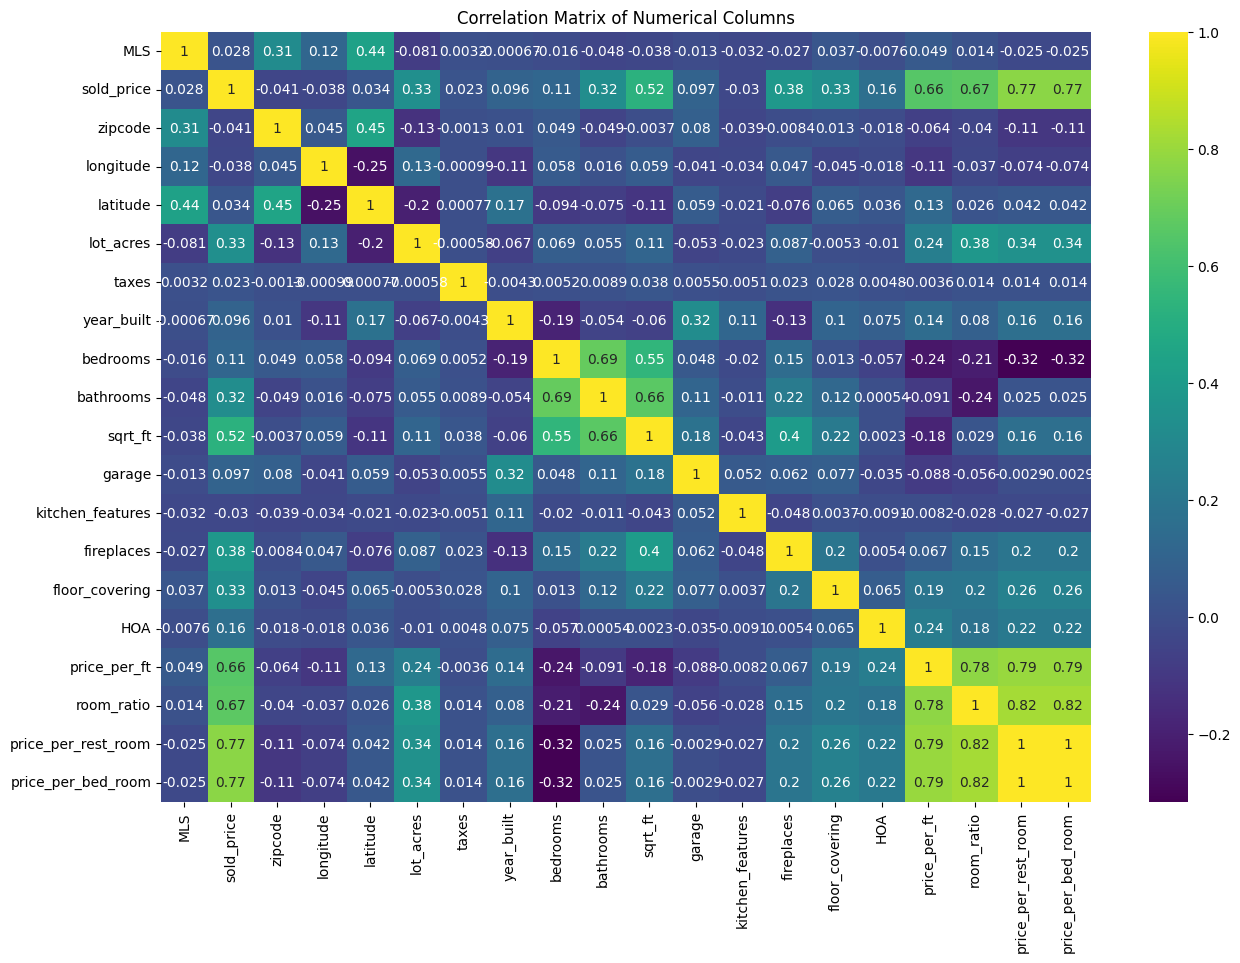

In [532]:
# # convert floor_covering and kitchen_features to binaries
# df['floor_covering'] = df['floor_covering'].map({'standard':0,'luxury':1})
# df['kitchen_features'] = df['kitchen_features'].map({'standard':0,'luxury':1})

# # plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

# title of correlation matrix
plt.title('Correlation Matrix of Numerical Columns')

In [516]:
# sold price is moderately positivitely correlated with sqrt_ft,fireplaces,bathrooms
# sold price is shows a weak positve correlations with bedrooms,HOA monthly fees,bedrooms,lot_acres
# bizzarely taxes barely has any correlation with any of the other numerical columns

In [517]:
# there is very strong correlation between sqrt_ft and bathrooms
# there is a strong positive correlation between bedrooms and bathrooms
# this suggest some degree of multi-collinearity the features which may affect our model if not addressed 

The taxes column is on average ~ 1% the value of the price sold. this is consistent which the true value as
described in this source https://smartasset.com/taxes/arizona-property-tax-calculator#arizona

so perhaps we neednt worry about suspected outliers for taxes.

In [518]:
# Calculate the ratio of column1 to column2
ratios = df['taxes'] / df['sold_price']

# Calculate the average ratio
average_ratio = ratios.mean()

print("Average times larger column1 is compared to column2:", average_ratio)

Average times larger column1 is compared to column2: 0.011494477750740502


Location

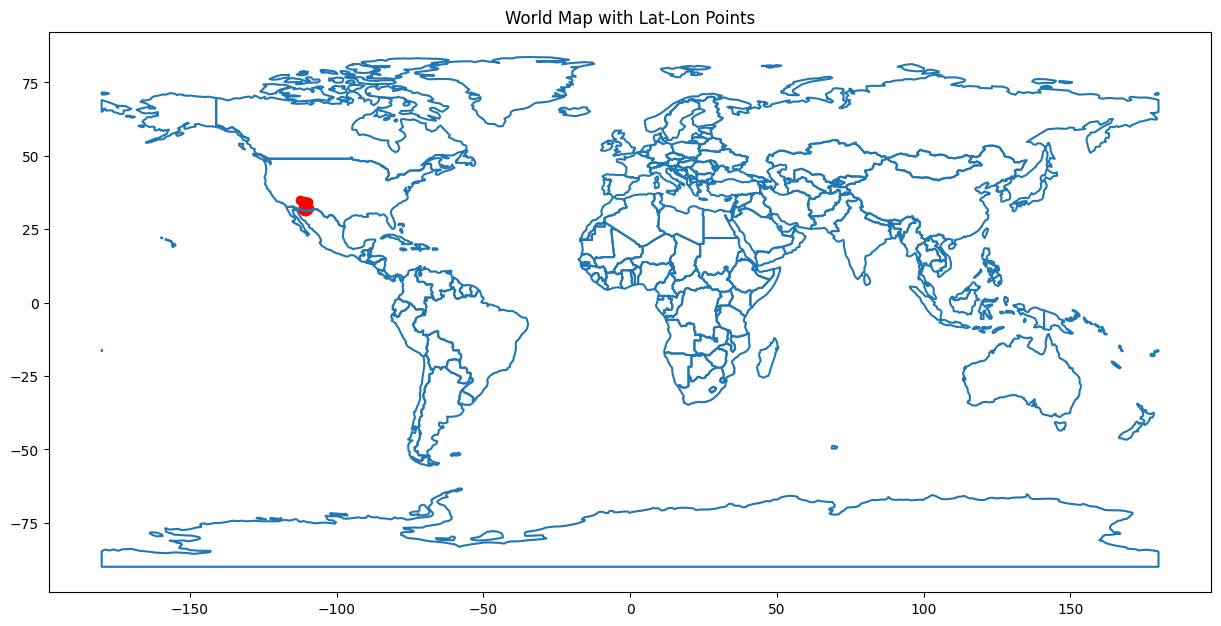

In [519]:
# plot longitutude and latitude against a world map

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting
fig, ax = plt.subplots(figsize=(15, 10))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, color='red')

# add title to the plot
plt.title('World Map with Lat-Lon Points')
plt.show()

# diagram shows the that the properties are located in the US Arizona/New Mexico and Mexico 

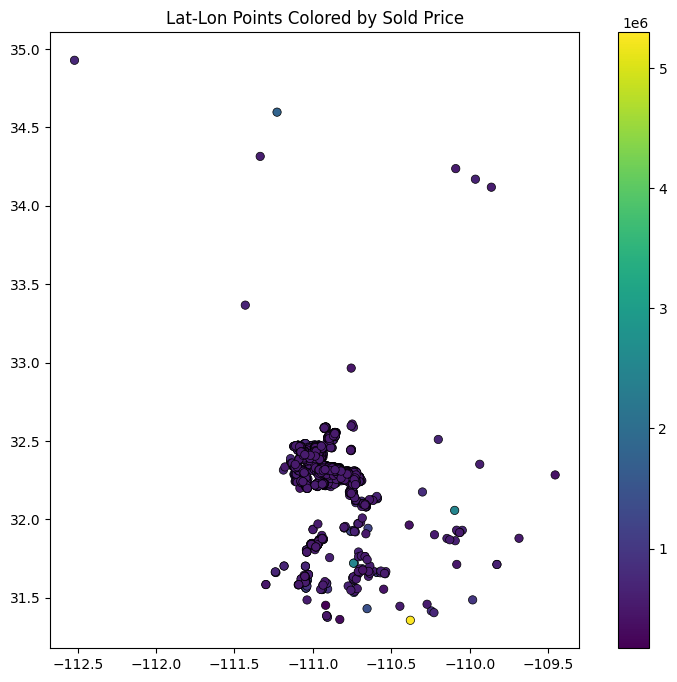

In [520]:
# there doesnt appear to be any clear trend in prices with location or any sort of clusters


# Assuming 'df' is your DataFrame and it includes 'longitude', 'latitude', and 'sold_price' columns
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

lat_min, lat_max = 14, 55
lon_min, lon_max = -113, -109
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 8))

# Adjust the plot to color by 'sold_price'
sc = gdf.cx[lon_min:lon_max, lat_min:lat_max].plot(ax=ax, column='sold_price', cmap='viridis', legend=True, marker='o', edgecolor='k', linewidth=0.5)

plt.title('Lat-Lon Points Colored by Sold Price')
plt.show()

Feature Engineering

Following the convention found on https://www.realtor.com/realestateandhomes-search/Pima-County_AZ/overview
it would seem that price_per_ft is an industry metric so I think it'll be good for my analysis

In [521]:
# price per ft
df['price_per_ft'] = (df['sold_price'] / df['sqrt_ft'])
# this new feature is the now the most correlated with sold price

In [522]:
# moreover the median price per ft is quick close to the known median price per ft for pima county which ~ $224
df['price_per_ft'].median()

202.1009393261022

In [531]:
#new amazing feature
df['price_per_bed_room']=df['sold_price']/df['bedrooms']

Conclusion

Comments About the Dataset and Sample

Sample Representation: A significant difference between the sample mean and the population mean might indicate that the sample is not representative of the population. This could be due to biased sampling methods or insufficient sample size. we could employ statistical tests to confirm it especially concerning with HOA.


Modeling Implications

Model Bias: The sample of houses is primarily associated with prices in Arizona, the model may not generalise
well if used to predict houses from other zipcodes.


Recommendation:

those the data provided seems for the most part of sound quality. If the task at hand is to predict the 
price sold of a property. it would be beneficial to have data houses previous listing price as:

1. it seems to be scrapable on some realtor sites 
2. its likely the biggest predictor of the selling price of a household
3. employ statistical tests against the known population means to test if the data is representative
4. address model collinearity further down the line
5. decide 